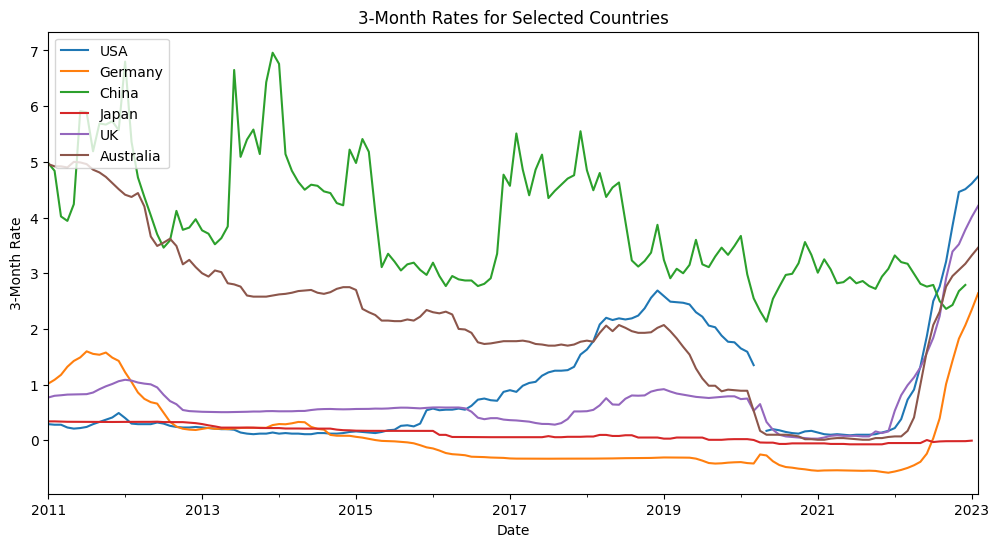

[*********************100%***********************]  6 of 6 completed


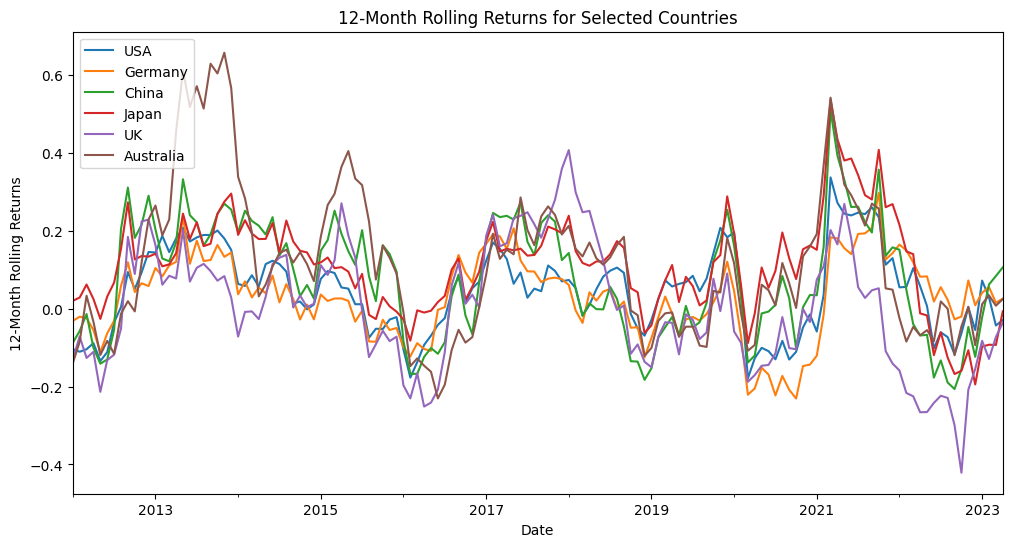

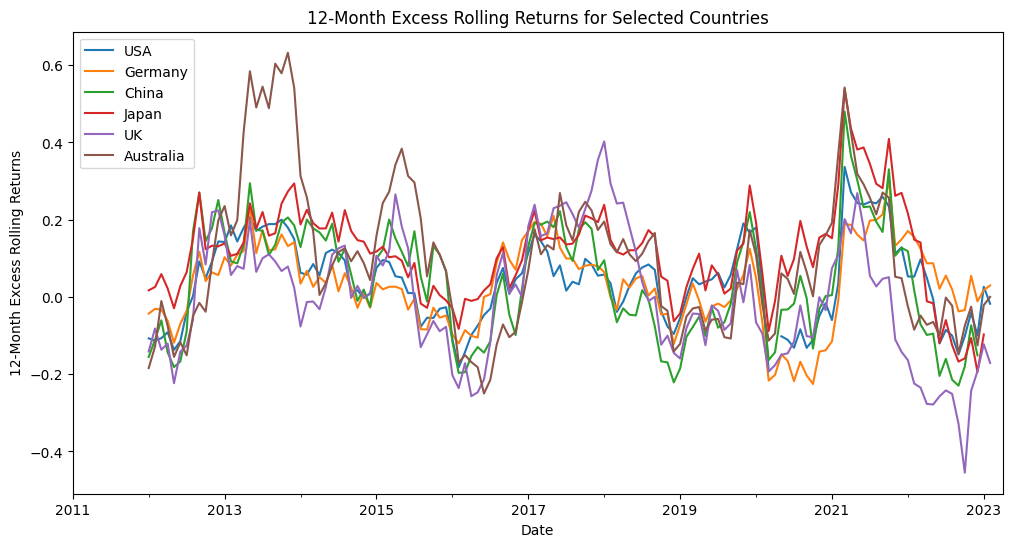

[*********************100%***********************]  7 of 7 completed


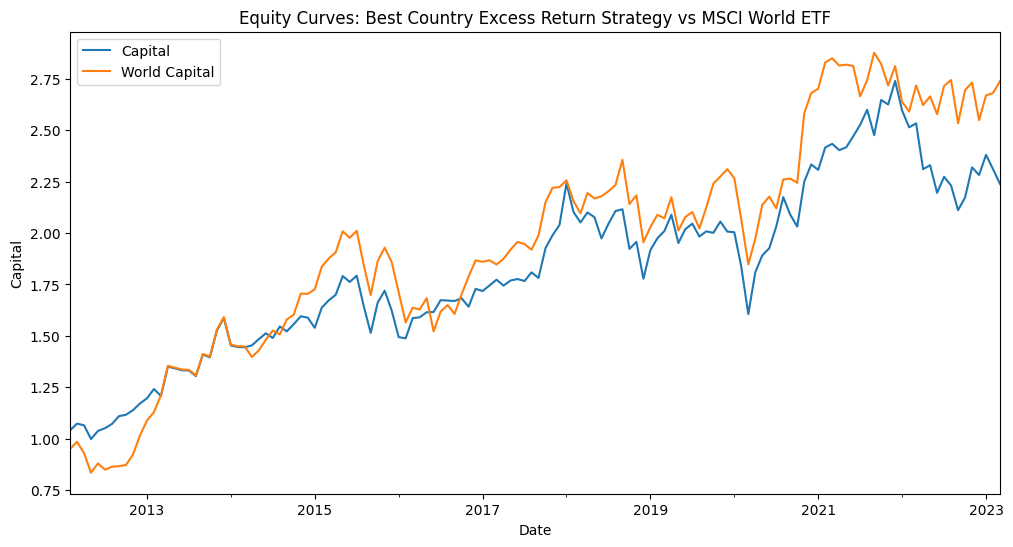

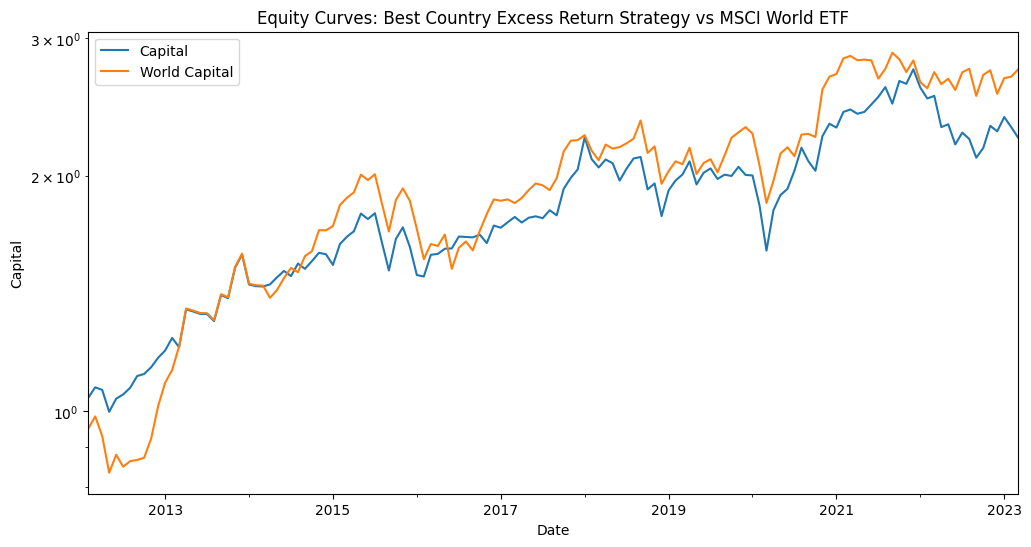

CAGR Best Country Excess Return Strategy: 5.15%
Mdd Best Country Excess Return Strategy: -28.38%
CAGR MSCI World ETF: 6.48%
Mdd MSCI World ETF: -24.33%


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from empyrical import max_drawdown, annual_return, annual_volatility, sharpe_ratio, sortino_ratio
from fredapi import Fred

# Set your FRED API key
api_key = "2f15c96b46530fde1b1992a64c64650e"
fred = Fred(api_key=api_key)

# Define the FRED series IDs for each country's 3-month rate
country_series = {
    "USA": "IR3TIB01USM156N",
    "Germany": "IR3TIB01DEM156N",
    "China": "IR3TIB01CNM156N",
    "Japan": "IR3TIB01JPM156N",
    "UK": "IR3TIB01GBM156N",
    "Australia": "IR3TIB01AUM156N"
}

# Specify the start date for the series
start_date = "2011-01-01"

# Download 3-month rate data for each country
country_data = {}
for country, series_id in country_series.items():
    country_data[country] = fred.get_series(series_id, start_date)
    
# Combine the data into a single DataFrame
combined_data = pd.concat(country_data, axis=1)

# Plot the 3-month rates
combined_data.plot(figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("3-Month Rate")
plt.title("3-Month Rates for Selected Countries")
plt.legend(loc="upper left")
plt.show()

# Define ETF tickers for each country
etf_tickers = {
    "USA": "^GSPC",
    "Germany": "^GDAXI",
    "China": "^HSI",
    "Japan": "^N225",
    "UK": "^FTSE",
    "Australia": "^AXJO"
}

# Download historical data for the ETFs
etf_data = yf.download(list(etf_tickers.values()), start=start_date, interval='1mo')['Close']

# Rename columns to match country names
etf_data.columns = etf_tickers.keys()

# Calculate the monthly returns for each country ETF
etf_monthly_returns = etf_data.pct_change()

# Calculate the 6-month rolling returns for each country ETF
etf_12_month_rolling_returns = etf_monthly_returns.rolling(12).apply(lambda x: (x + 1).prod() - 1).dropna()


normalized_rates=combined_data.apply(lambda x: (x/100))

# Plot the 6-month rolling returns for each country ETF
etf_12_month_rolling_returns.plot(figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("12-Month Rolling Returns")
plt.title("12-Month Rolling Returns for Selected Countries")
plt.legend(loc="upper left")
plt.show()

excess_returns = etf_12_month_rolling_returns.subtract(normalized_rates, axis=0)
excess_returns.plot(figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("12-Month Excess Rolling Returns")
plt.title("12-Month Excess Rolling Returns for Selected Countries")
plt.legend(loc="upper left")
plt.show()


# Shift the excess returns by one month to avoid look-ahead bias
excess_returns_shifted = excess_returns.shift(1)

# Initialize variables for the backtest
capital = 1
transaction_fee = 0.000  # 0.1% fee
equity_curve = []
prev_best_idx = None

# Perform the backtest by iterating through each month
for date in excess_returns_shifted.index:
    # Skip the first month
    if pd.isna(excess_returns_shifted.loc[date]).all():
        continue
    best_idx = excess_returns_shifted.loc[date].idxmax()
    # Skip the month if the best index is NaN
    if pd.isna(best_idx):
        continue
    # Apply transaction fee if switching to a different ETF
    if best_idx != prev_best_idx:
        capital *= (1 - transaction_fee)
        prev_best_idx = best_idx
        
    # Calculate the monthly return of the best ETF
    monthly_return = etf_monthly_returns.loc[date, best_idx]
    # Update capital
    capital *= (1 + monthly_return)
    equity_curve.append((date, capital))
   
# Convert the equity curve to a DataFrame
equity_curve_df = pd.DataFrame(equity_curve, columns=["Date", "Capital"]).set_index("Date")


# Add the MSCI World ETF ticker to the etf_tickers dictionary
etf_tickers["World"] = "URTH"

# Download historical data for the ETFs, including the MSCI World ETF
etf_data = yf.download(list(etf_tickers.values()), start=start_date, interval='1mo')['Close']

# Rename columns to match country names
etf_data.columns = etf_tickers.keys()

# Calculate the monthly returns for each country ETF, including the MSCI World ETF
etf_monthly_returns = etf_data.pct_change()

# Initialize variables for the MSCI World ETF equity curve
world_capital = 1
world_equity_curve = []

# Calculate the equity curve for the MSCI World ETF
for date, monthly_return in etf_monthly_returns['World'].items():
    if not pd.isna(monthly_return):
        world_capital *= (1 + monthly_return)
        world_equity_curve.append((date, world_capital))
        
world_equity_curve_df = pd.DataFrame(world_equity_curve, columns=["Date", "World Capital"]).set_index("Date")

# Merge the equity curves for the Best Country Excess Return Strategy and the MSCI World ETF
merged_equity_curves = equity_curve_df.merge(world_equity_curve_df, left_index=True, right_index=True)

# Plot the merged equity curves
merged_equity_curves.plot(figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("Capital")
plt.title("Equity Curves: Best Country Excess Return Strategy vs MSCI World ETF")
plt.legend(loc="upper left")
plt.show()


# Plot the merged equity curves
merged_equity_curves.plot(figsize=(12, 6))
plt.yscale("log")
plt.xlabel("Date")
plt.ylabel("Capital")
plt.title("Equity Curves: Best Country Excess Return Strategy vs MSCI World ETF")
plt.legend(loc="upper left")
plt.show()


total_years = (merged_equity_curves.index[-1] - merged_equity_curves.index[0]).days / 252

# Calculate CAGR for Best Country Excess Return Strategy
initial_capital = 1
final_capital_best_strategy = merged_equity_curves['Capital'][-1]
cagr_best_strategy = (final_capital_best_strategy / initial_capital) ** (1 / total_years) - 1

# Calculate CAGR for MSCI World ETF
final_capital_world_etf = merged_equity_curves['World Capital'][-1]
cagr_world_etf = (final_capital_world_etf / initial_capital) ** (1 / total_years) - 1

# Calculate maximum drawdown for Best Country Excess Return Strategy
best_strategy_drawdown = (merged_equity_curves['Capital'] / merged_equity_curves['Capital'].cummax()) - 1
max_drawdown_best_strategy = best_strategy_drawdown.min()
# Calculate maximum drawdown for MSCI World ETF
world_etf_drawdown = (merged_equity_curves['World Capital'] / merged_equity_curves['World Capital'].cummax()) - 1
max_drawdown_world_etf = world_etf_drawdown.min()

# Print the CAGR for both strategies
print(f"CAGR Best Country Excess Return Strategy: {cagr_best_strategy * 100:.2f}%")
print(f"Mdd Best Country Excess Return Strategy: {max_drawdown_best_strategy * 100:.2f}%")
print(f"CAGR MSCI World ETF: {cagr_world_etf * 100:.2f}%")
print(f"Mdd MSCI World ETF: {max_drawdown_world_etf * 100:.2f}%")

